# Battery Forecasting with DeepAR

In this notebook we'll build a battery forecasting model with DeepAR to predict battery outages and emmit preventive alerts.

"The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN)."

Import pandas and recover stored data:

In [1]:
import pandas as pd
from matplotlib import pyplot

In [2]:
%store -r data

## Exploratory Data Analysis

Visualize the battery time series for a single device:

In [3]:
device_pos = 1
sample_device_id = data.iloc[device_pos]["device_id"]
sample_device_id

'8e4a851ed2317a249a0903f29d894361'

In [4]:
sample_data = data[data["device_id"] == sample_device_id]

In [5]:
battery = sample_data["battery"]

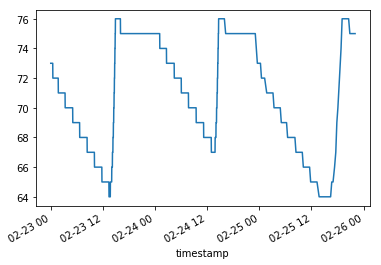

In [6]:
battery.plot()
pyplot.show()

## Time Series Resampling

The DeepAR input format requires data to be uniformly sampled. In the dataset, we can see that the sample timestamps are no regularly spaced, but actualy reflects the observation time:

In [7]:
battery.tail()

timestamp
2020-02-25 20:50:37    75
2020-02-25 21:07:07    75
2020-02-25 21:23:15    75
2020-02-25 21:38:36    75
2020-02-25 22:03:11    75
Name: battery, dtype: int64

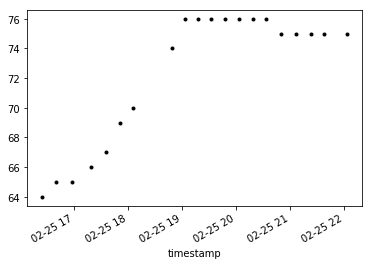

In [8]:
battery.tail(20).plot(style="k.")

Also, note that observation are taken about every 5 minutes, but changing little.
Pandas offers a convenient resampling function to create a uniform hourly dataset:

In [9]:
hourly = data[data["battery"] > 0]
hourly = (hourly.groupby("device_id")
          .battery
          .resample("H")
          .min())

In [10]:
hourly

device_id                         timestamp          
0001495ce5f079703599a94c32dab2b0  2020-02-24 15:00:00    75.0
                                  2020-02-24 16:00:00    75.0
                                  2020-02-24 17:00:00    75.0
                                  2020-02-24 18:00:00    75.0
                                  2020-02-24 19:00:00    75.0
                                                         ... 
fffaee1fbb9c96703850f64d3262e843  2020-02-25 17:00:00    64.0
                                  2020-02-25 18:00:00    68.0
                                  2020-02-25 19:00:00    75.0
                                  2020-02-25 20:00:00    76.0
                                  2020-02-25 21:00:00    76.0
Name: battery, Length: 532029, dtype: float64

In [11]:
hourly = hourly.reset_index().set_index("timestamp")

In [12]:
hourly

,device_id,battery
timestamp,,
2020-02-24 15:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 16:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 17:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 18:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 19:00:00,0001495ce5f079703599a94c32dab2b0,75.0
...,...,...
2020-02-25 17:00:00,fffaee1fbb9c96703850f64d3262e843,64.0
2020-02-25 18:00:00,fffaee1fbb9c96703850f64d3262e843,68.0
2020-02-25 19:00:00,fffaee1fbb9c96703850f64d3262e843,75.0


Let's again visualize a sample tame series:

In [13]:
hsample = hourly[hourly["device_id"] == sample_device_id]

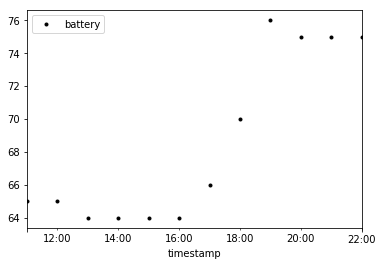

In [14]:
hsample.tail(12).plot(style="k.")

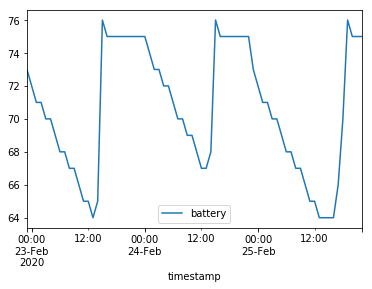

In [15]:
hsample.plot()

## Cross Validation

Take the last hours in the dataset for testing against predictions:

In [16]:
last_time = hourly.tail(1).index[0]
last_time

Timestamp('2020-02-25 21:00:00')

In [57]:
cut_time = last_time - pd.Timedelta('3 hour')
cut_time

Timestamp('2020-02-25 18:00:00')

In [18]:
train_set = hourly.loc[hourly.index <= cut_time]
train_set.tail()

,device_id,battery
timestamp,,
2020-02-25 14:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 15:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 16:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 17:00:00,fffaee1fbb9c96703850f64d3262e843,64.0
2020-02-25 18:00:00,fffaee1fbb9c96703850f64d3262e843,68.0


In [19]:
test_set = hourly.loc[hourly.index > cut_time]
test_set.head()

,device_id,battery
timestamp,,
2020-02-25 19:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 20:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 21:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 19:00:00,00134c004e33e830e5dbce3355a485b9,76.0
2020-02-25 20:00:00,00134c004e33e830e5dbce3355a485b9,76.0


In [20]:
sample_train = train_set[train_set["device_id"] == sample_device_id]["battery"]
sample_test = test_set[test_set["device_id"] == sample_device_id]

In [21]:
sample_train.tail()

timestamp
2020-02-25 14:00:00    64.0
2020-02-25 15:00:00    64.0
2020-02-25 16:00:00    64.0
2020-02-25 17:00:00    66.0
2020-02-25 18:00:00    70.0
Name: battery, dtype: float64

In [22]:
sample_test.head()

,device_id,battery
timestamp,,
2020-02-25 19:00:00,8e4a851ed2317a249a0903f29d894361,76.0
2020-02-25 20:00:00,8e4a851ed2317a249a0903f29d894361,75.0
2020-02-25 21:00:00,8e4a851ed2317a249a0903f29d894361,75.0
2020-02-25 22:00:00,8e4a851ed2317a249a0903f29d894361,75.0


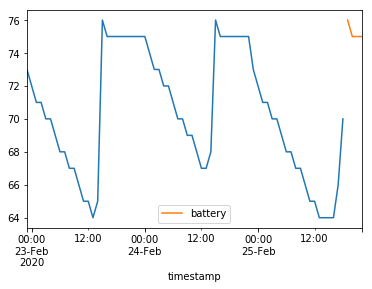

In [23]:
ax = sample_train.plot()
sample_test.plot(ax=ax)

Convert the data from pandas DataFrame to the expeted JSON Lines:

In [24]:
import json
import math

def df_to_tss(dataframe):
    df = dataframe.copy()
    df["timeindex"] = df.index
    cats = {}
    tss = {}
    for index, row in df.iterrows():
        target = row["battery"]
        if not(math.isnan(target)):
            identity = row["device_id"]
            cat = cats.get(identity)
            if not cat:
                cat = len(cats)
                start = str(row["timeindex"])
                ts = {
                    "start": start,
                    "cat": [cat],
                    "target": [],
                }
                cats[identity] = cat
                tss[cat] = ts
            ts = tss.get(cat)
            ts["target"].append(target)
    return tss

def tss_to_jsonl(tss):  
    result = ""
    for key, value in tss.items():
        jsonll = json.dumps(value)
        result += jsonll
        result += "\n"
    return result[:-1]

def df_to_jsonl(dataframe):
    return tss_to_jsonl(df_to_tss(dataframe))

In [25]:

import time
start = time.time()
jsonl = df_to_jsonl(train_set.head(100))
elapsed = time.time() - start
print(elapsed)
print(jsonl)

0.01669764518737793
{"start": "2020-02-24 15:00:00", "cat": [0], "target": [75.0]}
{"start": "2020-02-24 15:00:00", "cat": [1], "target": [76.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 73.0, 72.0, 71.0, 71.0, 70.0, 69.0, 69.0, 68.0, 68.0, 67.0, 66.0, 66.0, 65.0, 65.0, 64.0, 64.0, 63.0, 64.0, 65.0, 69.0]}
{"start": "2020-02-24 15:00:00", "cat": [2], "target": [75.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 73.0, 72.0, 71.0, 71.0, 70.0, 69.0, 68.0, 68.0, 67.0, 67.0, 66.0, 66.0, 65.0, 64.0, 64.0, 63.0, 63.0, 63.0, 65.0, 68.0]}
{"start": "2020-02-24 15:00:00", "cat": [3], "target": [76.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 73.0, 72.0, 72.0, 71.0, 70.0, 70.0, 69.0, 69.0]}


In [26]:
import time
start = time.time()

train_tss = df_to_tss(train_set)
train_jsonl = tss_to_jsonl(train_tss)

test_tss = df_to_tss(test_set)
test_jsonl = tss_to_jsonl(test_tss)

elapsed = time.time() - start
print(elapsed)

64.34777522087097


In [27]:
import pathlib

prefix = "mt-battery-deepar"
input_path = "./{}/input".format(prefix)

train_path = "{}/train.json".format(input_path)
test_path = "{}/test.json".format(input_path)
(train_path,test_path)

('./mt-battery-deepar/input/train.json', './mt-battery-deepar/input/test.json')

In [28]:
import shutil

shutil.rmtree(input_path, ignore_errors=True)
pathlib.Path(input_path).mkdir(parents=True, exist_ok=True)

In [29]:
with open(train_path, "w") as text_file:
    print(train_jsonl, file=text_file)

with open(test_path, "w") as text_file:
    print(test_jsonl, file=text_file)

In [30]:
! ls -liah "{input_path}/"

total 5.0M
393217 drwxrwxr-x 2 ec2-user ec2-user 4.0K May 13 14:12 .
 81921 drwxrwxr-x 3 ec2-user ec2-user 4.0K May 13 14:12 ..
393219 -rw-rw-r-- 1 ec2-user ec2-user 1.3M May 13 14:12 test.json
393218 -rw-rw-r-- 1 ec2-user ec2-user 3.8M May 13 14:12 train.json


Upload train and test sets to S3:

In [31]:
%store -r bucket

In [32]:
!aws s3 sync "{input_path}/" "s3://{bucket}/{prefix}/" --delete

delete: s3://mt-ml-workshop-wzejasmw/mt-battery-deepar/output/mt-battery-deepar-2020-05-13-13-08-04-174/output/model.tar.gz
delete: s3://mt-ml-workshop-wzejasmw/mt-battery-deepar/output/mt-battery-deepar-2020-05-13-13-14-37-886/output/model.tar.gz
upload: mt-battery-deepar/input/test.json to s3://mt-ml-workshop-wzejasmw/mt-battery-deepar/test.json
upload: mt-battery-deepar/input/train.json to s3://mt-ml-workshop-wzejasmw/mt-battery-deepar/train.json


In [33]:
!aws s3 ls "s3://{bucket}/{prefix}/" 

2020-05-13 14:12:40    1325499 test.json
2020-05-13 14:12:40    3906490 train.json


In [34]:
dar_input = {
    "train": "s3://{}/{}/train.json".format(bucket,prefix),
    "test": "s3://{}/{}/test.json".format(bucket,prefix)
}
dar_input

{'train': 's3://mt-ml-workshop-wzejasmw/mt-battery-deepar/train.json',
 'test': 's3://mt-ml-workshop-wzejasmw/mt-battery-deepar/test.json'}

## DeepAR Training

https://aws.amazon.com/sagemaker/pricing/instance-types/

In [35]:
train_instance_type='ml.c5.2xlarge' #Estimated Training Time: 

In [36]:
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

dar_image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
dar_image_name

'224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:1'

In [37]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

dar_estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=dar_image_name,
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    base_job_name=prefix,
    output_path="s3://{}/{}/output/".format(bucket,prefix)
)

In [38]:
freq = 'H'
prediction_length = 4
context_length = 12

In [39]:

dar_hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
    "cardinality": "auto",
    "num_dynamic_feat":"ignore"
}
dar_estimator.set_hyperparameters(**dar_hyperparameters)

In [40]:
dar_estimator.fit(inputs=dar_input)

2020-05-13 14:12:42 Starting - Starting the training job...
2020-05-13 14:12:43 Starting - Launching requested ML instances......
2020-05-13 14:13:45 Starting - Preparing the instances for training...
2020-05-13 14:14:41 Downloading - Downloading input data...
2020-05-13 14:15:07 Training - Downloading the training image..Arguments: train
[05/13/2020 14:15:23 INFO 140253952157504] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[05/13/2020 14:15:23 I

[05/13/2020 14:15:37 INFO 140253952157504] Epoch[0] Batch[450] avg_epoch_loss=1.922729
[05/13/2020 14:15:37 INFO 140253952157504] #quality_metric: host=algo-1, epoch=0, batch=450 train loss <loss>=1.37370383739
[05/13/2020 14:15:37 INFO 140253952157504] Epoch[0] Batch [450]#011Speed: 1692.04 samples/sec#011loss=1.373704
[05/13/2020 14:15:37 INFO 140253952157504] Epoch[0] Batch[455] avg_epoch_loss=1.919334
[05/13/2020 14:15:37 INFO 140253952157504] #quality_metric: host=algo-1, epoch=0, batch=455 train loss <loss>=1.61311402321
[05/13/2020 14:15:37 INFO 140253952157504] Epoch[0] Batch [455]#011Speed: 1169.47 samples/sec#011loss=1.613114
[05/13/2020 14:15:37 INFO 140253952157504] Epoch[0] Batch[460] avg_epoch_loss=1.914795
[05/13/2020 14:15:37 INFO 140253952157504] #quality_metric: host=algo-1, epoch=0, batch=460 train loss <loss>=1.5007673502
[05/13/2020 14:15:37 INFO 140253952157504] Epoch[0] Batch [460]#011Speed: 1123.58 samples/sec#011loss=1.500767
[05/13/2020 14:15:37 INFO 140253952

[05/13/2020 14:15:47 INFO 140253952157504] Epoch[1] Batch[305] avg_epoch_loss=1.495512
[05/13/2020 14:15:47 INFO 140253952157504] #quality_metric: host=algo-1, epoch=1, batch=305 train loss <loss>=1.35747988224
[05/13/2020 14:15:47 INFO 140253952157504] Epoch[1] Batch [305]#011Speed: 1699.79 samples/sec#011loss=1.357480
[05/13/2020 14:15:47 INFO 140253952157504] Epoch[1] Batch[310] avg_epoch_loss=1.494269
[05/13/2020 14:15:47 INFO 140253952157504] #quality_metric: host=algo-1, epoch=1, batch=310 train loss <loss>=1.41816282272
[05/13/2020 14:15:47 INFO 140253952157504] Epoch[1] Batch [310]#011Speed: 1171.90 samples/sec#011loss=1.418163
[05/13/2020 14:15:47 INFO 140253952157504] Epoch[1] Batch[315] avg_epoch_loss=1.496369
[05/13/2020 14:15:47 INFO 140253952157504] #quality_metric: host=algo-1, epoch=1, batch=315 train loss <loss>=1.62700800896
[05/13/2020 14:15:47 INFO 140253952157504] Epoch[1] Batch [315]#011Speed: 1577.89 samples/sec#011loss=1.627008
[05/13/2020 14:15:47 INFO 14025395

[05/13/2020 14:15:57 INFO 140253952157504] Epoch[2] Batch[155] avg_epoch_loss=1.385554
[05/13/2020 14:15:57 INFO 140253952157504] #quality_metric: host=algo-1, epoch=2, batch=155 train loss <loss>=1.39117157459
[05/13/2020 14:15:57 INFO 140253952157504] Epoch[2] Batch [155]#011Speed: 1076.55 samples/sec#011loss=1.391172
[05/13/2020 14:15:57 INFO 140253952157504] Epoch[2] Batch[160] avg_epoch_loss=1.380262
[05/13/2020 14:15:57 INFO 140253952157504] #quality_metric: host=algo-1, epoch=2, batch=160 train loss <loss>=1.21515009403
[05/13/2020 14:15:57 INFO 140253952157504] Epoch[2] Batch [160]#011Speed: 1567.14 samples/sec#011loss=1.215150
[05/13/2020 14:15:57 INFO 140253952157504] Epoch[2] Batch[165] avg_epoch_loss=1.378658
[05/13/2020 14:15:57 INFO 140253952157504] #quality_metric: host=algo-1, epoch=2, batch=165 train loss <loss>=1.32700543404
[05/13/2020 14:15:57 INFO 140253952157504] Epoch[2] Batch [165]#011Speed: 1177.75 samples/sec#011loss=1.327005
[05/13/2020 14:15:57 INFO 14025395

[05/13/2020 14:16:12 INFO 140253952157504] Epoch[3] Batch[210] avg_epoch_loss=1.300512
[05/13/2020 14:16:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=3, batch=210 train loss <loss>=1.97236180305
[05/13/2020 14:16:12 INFO 140253952157504] Epoch[3] Batch [210]#011Speed: 1102.47 samples/sec#011loss=1.972362
[05/13/2020 14:16:12 INFO 140253952157504] Epoch[3] Batch[215] avg_epoch_loss=1.301541
[05/13/2020 14:16:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=3, batch=215 train loss <loss>=1.34496004581
[05/13/2020 14:16:12 INFO 140253952157504] Epoch[3] Batch [215]#011Speed: 1607.17 samples/sec#011loss=1.344960
[05/13/2020 14:16:12 INFO 140253952157504] Epoch[3] Batch[220] avg_epoch_loss=1.303607
[05/13/2020 14:16:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=3, batch=220 train loss <loss>=1.39285550117
[05/13/2020 14:16:12 INFO 140253952157504] Epoch[3] Batch [220]#011Speed: 1076.09 samples/sec#011loss=1.392856
[05/13/2020 14:16:12 INFO 14025395

[05/13/2020 14:16:17 INFO 140253952157504] Epoch[3] Batch[415] avg_epoch_loss=1.290021
[05/13/2020 14:16:17 INFO 140253952157504] #quality_metric: host=algo-1, epoch=3, batch=415 train loss <loss>=1.44651693106
[05/13/2020 14:16:17 INFO 140253952157504] Epoch[3] Batch [415]#011Speed: 1111.66 samples/sec#011loss=1.446517
[05/13/2020 14:16:17 INFO 140253952157504] Epoch[3] Batch[420] avg_epoch_loss=1.289401
[05/13/2020 14:16:17 INFO 140253952157504] #quality_metric: host=algo-1, epoch=3, batch=420 train loss <loss>=1.2378282547
[05/13/2020 14:16:17 INFO 140253952157504] Epoch[3] Batch [420]#011Speed: 1598.93 samples/sec#011loss=1.237828
[05/13/2020 14:16:17 INFO 140253952157504] Epoch[3] Batch[425] avg_epoch_loss=1.296691
[05/13/2020 14:16:17 INFO 140253952157504] #quality_metric: host=algo-1, epoch=3, batch=425 train loss <loss>=1.91048741341
[05/13/2020 14:16:17 INFO 140253952157504] Epoch[3] Batch [425]#011Speed: 1069.30 samples/sec#011loss=1.910487
[05/13/2020 14:16:17 INFO 140253952

[05/13/2020 14:16:27 INFO 140253952157504] Epoch[4] Batch[265] avg_epoch_loss=1.314223
[05/13/2020 14:16:27 INFO 140253952157504] #quality_metric: host=algo-1, epoch=4, batch=265 train loss <loss>=1.26576282978
[05/13/2020 14:16:27 INFO 140253952157504] Epoch[4] Batch [265]#011Speed: 1721.82 samples/sec#011loss=1.265763
[05/13/2020 14:16:27 INFO 140253952157504] Epoch[4] Batch[270] avg_epoch_loss=1.310073
[05/13/2020 14:16:27 INFO 140253952157504] #quality_metric: host=algo-1, epoch=4, batch=270 train loss <loss>=1.08927254677
[05/13/2020 14:16:27 INFO 140253952157504] Epoch[4] Batch [270]#011Speed: 1069.82 samples/sec#011loss=1.089273
[05/13/2020 14:16:27 INFO 140253952157504] Epoch[4] Batch[275] avg_epoch_loss=1.305682
[05/13/2020 14:16:27 INFO 140253952157504] #quality_metric: host=algo-1, epoch=4, batch=275 train loss <loss>=1.06768620014
[05/13/2020 14:16:27 INFO 140253952157504] Epoch[4] Batch [275]#011Speed: 1751.62 samples/sec#011loss=1.067686
[05/13/2020 14:16:27 INFO 14025395

[05/13/2020 14:16:37 INFO 140253952157504] Epoch[5] Batch[110] avg_epoch_loss=1.254875
[05/13/2020 14:16:37 INFO 140253952157504] #quality_metric: host=algo-1, epoch=5, batch=110 train loss <loss>=1.40428647995
[05/13/2020 14:16:37 INFO 140253952157504] Epoch[5] Batch [110]#011Speed: 1144.98 samples/sec#011loss=1.404286
[05/13/2020 14:16:37 INFO 140253952157504] Epoch[5] Batch[115] avg_epoch_loss=1.258277
[05/13/2020 14:16:37 INFO 140253952157504] #quality_metric: host=algo-1, epoch=5, batch=115 train loss <loss>=1.33382163048
[05/13/2020 14:16:37 INFO 140253952157504] Epoch[5] Batch [115]#011Speed: 1711.36 samples/sec#011loss=1.333822
[05/13/2020 14:16:37 INFO 140253952157504] Epoch[5] Batch[120] avg_epoch_loss=1.259500
[05/13/2020 14:16:37 INFO 140253952157504] #quality_metric: host=algo-1, epoch=5, batch=120 train loss <loss>=1.28787384033
[05/13/2020 14:16:37 INFO 140253952157504] Epoch[5] Batch [120]#011Speed: 1151.20 samples/sec#011loss=1.287874
[05/13/2020 14:16:37 INFO 14025395

[05/13/2020 14:16:52 INFO 140253952157504] Epoch[6] Batch[170] avg_epoch_loss=1.186818
[05/13/2020 14:16:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=6, batch=170 train loss <loss>=1.03914862871
[05/13/2020 14:16:52 INFO 140253952157504] Epoch[6] Batch [170]#011Speed: 1701.02 samples/sec#011loss=1.039149
[05/13/2020 14:16:52 INFO 140253952157504] Epoch[6] Batch[175] avg_epoch_loss=1.180244
[05/13/2020 14:16:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=6, batch=175 train loss <loss>=0.955406105518
[05/13/2020 14:16:52 INFO 140253952157504] Epoch[6] Batch [175]#011Speed: 1082.46 samples/sec#011loss=0.955406
[05/13/2020 14:16:52 INFO 140253952157504] Epoch[6] Batch[180] avg_epoch_loss=1.178288
[05/13/2020 14:16:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=6, batch=180 train loss <loss>=1.10943455696
[05/13/2020 14:16:52 INFO 140253952157504] Epoch[6] Batch [180]#011Speed: 1698.26 samples/sec#011loss=1.109435
[05/13/2020 14:16:52 INFO 1402539

[05/13/2020 14:17:02 INFO 140253952157504] Epoch[7] Batch[20] avg_epoch_loss=1.385279
[05/13/2020 14:17:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=7, batch=20 train loss <loss>=1.28216791153
[05/13/2020 14:17:02 INFO 140253952157504] Epoch[7] Batch [20]#011Speed: 1007.47 samples/sec#011loss=1.282168
[05/13/2020 14:17:02 INFO 140253952157504] Epoch[7] Batch[25] avg_epoch_loss=1.379063
[05/13/2020 14:17:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=7, batch=25 train loss <loss>=1.35295774937
[05/13/2020 14:17:02 INFO 140253952157504] Epoch[7] Batch [25]#011Speed: 1546.39 samples/sec#011loss=1.352958
[05/13/2020 14:17:02 INFO 140253952157504] Epoch[7] Batch[30] avg_epoch_loss=1.370262
[05/13/2020 14:17:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=7, batch=30 train loss <loss>=1.32449653149
[05/13/2020 14:17:02 INFO 140253952157504] Epoch[7] Batch [30]#011Speed: 1719.43 samples/sec#011loss=1.324497
[05/13/2020 14:17:02 INFO 140253952157504] 

[05/13/2020 14:17:12 INFO 140253952157504] Epoch[7] Batch[435] avg_epoch_loss=1.164493
[05/13/2020 14:17:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=7, batch=435 train loss <loss>=1.08132264614
[05/13/2020 14:17:12 INFO 140253952157504] Epoch[7] Batch [435]#011Speed: 1089.96 samples/sec#011loss=1.081323
[05/13/2020 14:17:12 INFO 140253952157504] Epoch[7] Batch[440] avg_epoch_loss=1.164654
[05/13/2020 14:17:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=7, batch=440 train loss <loss>=1.17865607738
[05/13/2020 14:17:12 INFO 140253952157504] Epoch[7] Batch [440]#011Speed: 1710.42 samples/sec#011loss=1.178656
[05/13/2020 14:17:12 INFO 140253952157504] Epoch[7] Batch[445] avg_epoch_loss=1.163763
[05/13/2020 14:17:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=7, batch=445 train loss <loss>=1.08523782492
[05/13/2020 14:17:12 INFO 140253952157504] Epoch[7] Batch [445]#011Speed: 1065.69 samples/sec#011loss=1.085238
[05/13/2020 14:17:12 INFO 14025395

[05/13/2020 14:17:22 INFO 140253952157504] Epoch[8] Batch[290] avg_epoch_loss=1.251254
[05/13/2020 14:17:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=8, batch=290 train loss <loss>=0.945889222622
[05/13/2020 14:17:22 INFO 140253952157504] Epoch[8] Batch [290]#011Speed: 1651.49 samples/sec#011loss=0.945889
[05/13/2020 14:17:22 INFO 140253952157504] Epoch[8] Batch[295] avg_epoch_loss=1.247182
[05/13/2020 14:17:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=8, batch=295 train loss <loss>=1.01019536257
[05/13/2020 14:17:22 INFO 140253952157504] Epoch[8] Batch [295]#011Speed: 1155.87 samples/sec#011loss=1.010195
[05/13/2020 14:17:22 INFO 140253952157504] Epoch[8] Batch[300] avg_epoch_loss=1.244415
[05/13/2020 14:17:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=8, batch=300 train loss <loss>=1.0806022048
[05/13/2020 14:17:22 INFO 140253952157504] Epoch[8] Batch [300]#011Speed: 1708.18 samples/sec#011loss=1.080602
[05/13/2020 14:17:22 INFO 14025395

[05/13/2020 14:17:32 INFO 140253952157504] Epoch[9] Batch[135] avg_epoch_loss=1.012366
[05/13/2020 14:17:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=9, batch=135 train loss <loss>=1.07963759899
[05/13/2020 14:17:32 INFO 140253952157504] Epoch[9] Batch [135]#011Speed: 1652.28 samples/sec#011loss=1.079638
[05/13/2020 14:17:32 INFO 140253952157504] Epoch[9] Batch[140] avg_epoch_loss=1.051527
[05/13/2020 14:17:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=9, batch=140 train loss <loss>=2.11670200825
[05/13/2020 14:17:32 INFO 140253952157504] Epoch[9] Batch [140]#011Speed: 1106.52 samples/sec#011loss=2.116702
[05/13/2020 14:17:32 INFO 140253952157504] Epoch[9] Batch[145] avg_epoch_loss=1.080903
[05/13/2020 14:17:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=9, batch=145 train loss <loss>=1.90930440426
[05/13/2020 14:17:32 INFO 140253952157504] Epoch[9] Batch [145]#011Speed: 1723.99 samples/sec#011loss=1.909304
[05/13/2020 14:17:32 INFO 14025395

[05/13/2020 14:17:42 INFO 140253952157504] Epoch[9] Batch[550] avg_epoch_loss=1.088472
[05/13/2020 14:17:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=9, batch=550 train loss <loss>=0.94300494194
[05/13/2020 14:17:42 INFO 140253952157504] Epoch[9] Batch [550]#011Speed: 1049.29 samples/sec#011loss=0.943005
[05/13/2020 14:17:42 INFO 140253952157504] Epoch[9] Batch[555] avg_epoch_loss=1.087174
[05/13/2020 14:17:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=9, batch=555 train loss <loss>=0.944146502018
[05/13/2020 14:17:42 INFO 140253952157504] Epoch[9] Batch [555]#011Speed: 1606.41 samples/sec#011loss=0.944147
[05/13/2020 14:17:42 INFO 140253952157504] processed a total of 17911 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 13496.978998184204, "sum": 13496.978998184204, "min": 13496.978998184204}}, "EndTime": 1589379462.66094, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1589379449.1636

[05/13/2020 14:17:52 INFO 140253952157504] Epoch[10] Batch[400] avg_epoch_loss=1.169747
[05/13/2020 14:17:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=10, batch=400 train loss <loss>=1.21070017815
[05/13/2020 14:17:52 INFO 140253952157504] Epoch[10] Batch [400]#011Speed: 1562.26 samples/sec#011loss=1.210700
[05/13/2020 14:17:52 INFO 140253952157504] Epoch[10] Batch[405] avg_epoch_loss=1.166446
[05/13/2020 14:17:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=10, batch=405 train loss <loss>=0.901667833328
[05/13/2020 14:17:52 INFO 140253952157504] Epoch[10] Batch [405]#011Speed: 1058.94 samples/sec#011loss=0.901668
[05/13/2020 14:17:52 INFO 140253952157504] Epoch[10] Batch[410] avg_epoch_loss=1.162736
[05/13/2020 14:17:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=10, batch=410 train loss <loss>=0.861538517475
[05/13/2020 14:17:52 INFO 140253952157504] Epoch[10] Batch [410]#011Speed: 1729.28 samples/sec#011loss=0.861539
[05/13/2020 14:17:52 IN

[05/13/2020 14:18:02 INFO 140253952157504] Epoch[11] Batch[245] avg_epoch_loss=1.099867
[05/13/2020 14:18:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=11, batch=245 train loss <loss>=1.01222081184
[05/13/2020 14:18:02 INFO 140253952157504] Epoch[11] Batch [245]#011Speed: 1614.32 samples/sec#011loss=1.012221
[05/13/2020 14:18:02 INFO 140253952157504] Epoch[11] Batch[250] avg_epoch_loss=1.095113
[05/13/2020 14:18:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=11, batch=250 train loss <loss>=0.861218559742
[05/13/2020 14:18:02 INFO 140253952157504] Epoch[11] Batch [250]#011Speed: 1016.79 samples/sec#011loss=0.861219
[05/13/2020 14:18:02 INFO 140253952157504] Epoch[11] Batch[255] avg_epoch_loss=1.092591
[05/13/2020 14:18:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=11, batch=255 train loss <loss>=0.96599894762
[05/13/2020 14:18:02 INFO 140253952157504] Epoch[11] Batch [255]#011Speed: 1689.78 samples/sec#011loss=0.965999
[05/13/2020 14:18:02 INF

[05/13/2020 14:18:12 INFO 140253952157504] Epoch[12] Batch[95] avg_epoch_loss=0.928983
[05/13/2020 14:18:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=12, batch=95 train loss <loss>=0.873761105537
[05/13/2020 14:18:12 INFO 140253952157504] Epoch[12] Batch [95]#011Speed: 1063.68 samples/sec#011loss=0.873761
[05/13/2020 14:18:12 INFO 140253952157504] Epoch[12] Batch[100] avg_epoch_loss=0.925008
[05/13/2020 14:18:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=12, batch=100 train loss <loss>=0.848701405525
[05/13/2020 14:18:12 INFO 140253952157504] Epoch[12] Batch [100]#011Speed: 1442.45 samples/sec#011loss=0.848701
[05/13/2020 14:18:12 INFO 140253952157504] Epoch[12] Batch[105] avg_epoch_loss=0.966988
[05/13/2020 14:18:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=12, batch=105 train loss <loss>=1.81497889757
[05/13/2020 14:18:12 INFO 140253952157504] Epoch[12] Batch [105]#011Speed: 1130.37 samples/sec#011loss=1.814979
[05/13/2020 14:18:12 INFO 

[05/13/2020 14:18:22 INFO 140253952157504] Epoch[12] Batch[505] avg_epoch_loss=1.082079
[05/13/2020 14:18:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=12, batch=505 train loss <loss>=0.991934907436
[05/13/2020 14:18:22 INFO 140253952157504] Epoch[12] Batch [505]#011Speed: 1708.05 samples/sec#011loss=0.991935
[05/13/2020 14:18:22 INFO 140253952157504] Epoch[12] Batch[510] avg_epoch_loss=1.080729
[05/13/2020 14:18:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=12, batch=510 train loss <loss>=0.944034838676
[05/13/2020 14:18:22 INFO 140253952157504] Epoch[12] Batch [510]#011Speed: 1010.00 samples/sec#011loss=0.944035
[05/13/2020 14:18:22 INFO 140253952157504] Epoch[12] Batch[515] avg_epoch_loss=1.078840
[05/13/2020 14:18:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=12, batch=515 train loss <loss>=0.885848760605
[05/13/2020 14:18:22 INFO 140253952157504] Epoch[12] Batch [515]#011Speed: 1713.30 samples/sec#011loss=0.885849
[05/13/2020 14:18:22 I

[05/13/2020 14:18:32 INFO 140253952157504] Epoch[13] Batch[350] avg_epoch_loss=1.097183
[05/13/2020 14:18:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=13, batch=350 train loss <loss>=0.955402636528
[05/13/2020 14:18:32 INFO 140253952157504] Epoch[13] Batch [350]#011Speed: 1091.46 samples/sec#011loss=0.955403
[05/13/2020 14:18:32 INFO 140253952157504] Epoch[13] Batch[355] avg_epoch_loss=1.094297
[05/13/2020 14:18:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=13, batch=355 train loss <loss>=0.891755926609
[05/13/2020 14:18:32 INFO 140253952157504] Epoch[13] Batch [355]#011Speed: 1744.19 samples/sec#011loss=0.891756
[05/13/2020 14:18:32 INFO 140253952157504] Epoch[13] Batch[360] avg_epoch_loss=1.092655
[05/13/2020 14:18:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=13, batch=360 train loss <loss>=0.97571284771
[05/13/2020 14:18:32 INFO 140253952157504] Epoch[13] Batch [360]#011Speed: 1001.25 samples/sec#011loss=0.975713
[05/13/2020 14:18:32 IN

[05/13/2020 14:18:42 INFO 140253952157504] Epoch[14] Batch[205] avg_epoch_loss=0.989466
[05/13/2020 14:18:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=14, batch=205 train loss <loss>=1.05162949562
[05/13/2020 14:18:42 INFO 140253952157504] Epoch[14] Batch [205]#011Speed: 1150.99 samples/sec#011loss=1.051629
[05/13/2020 14:18:42 INFO 140253952157504] Epoch[14] Batch[210] avg_epoch_loss=0.993703
[05/13/2020 14:18:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=14, batch=210 train loss <loss>=1.16823487282
[05/13/2020 14:18:42 INFO 140253952157504] Epoch[14] Batch [210]#011Speed: 1714.22 samples/sec#011loss=1.168235
[05/13/2020 14:18:42 INFO 140253952157504] Epoch[14] Batch[215] avg_epoch_loss=0.992590
[05/13/2020 14:18:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=14, batch=215 train loss <loss>=0.945641422272
[05/13/2020 14:18:42 INFO 140253952157504] Epoch[14] Batch [215]#011Speed: 1086.69 samples/sec#011loss=0.945641
[05/13/2020 14:18:42 INF

[05/13/2020 14:18:52 INFO 140253952157504] Epoch[15] Batch[55] avg_epoch_loss=0.923152
[05/13/2020 14:18:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=15, batch=55 train loss <loss>=0.90938782692
[05/13/2020 14:18:52 INFO 140253952157504] Epoch[15] Batch [55]#011Speed: 1136.24 samples/sec#011loss=0.909388
[05/13/2020 14:18:52 INFO 140253952157504] Epoch[15] Batch[60] avg_epoch_loss=0.923628
[05/13/2020 14:18:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=15, batch=60 train loss <loss>=0.928957641125
[05/13/2020 14:18:52 INFO 140253952157504] Epoch[15] Batch [60]#011Speed: 1702.35 samples/sec#011loss=0.928958
[05/13/2020 14:18:52 INFO 140253952157504] Epoch[15] Batch[65] avg_epoch_loss=0.929797
[05/13/2020 14:18:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=15, batch=65 train loss <loss>=1.00506074429
[05/13/2020 14:18:52 INFO 140253952157504] Epoch[15] Batch [65]#011Speed: 1127.66 samples/sec#011loss=1.005061
[05/13/2020 14:18:52 INFO 1402539

[05/13/2020 14:19:02 INFO 140253952157504] Epoch[15] Batch[470] avg_epoch_loss=0.990250
[05/13/2020 14:19:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=15, batch=470 train loss <loss>=0.959276843071
[05/13/2020 14:19:02 INFO 140253952157504] Epoch[15] Batch [470]#011Speed: 1637.58 samples/sec#011loss=0.959277
[05/13/2020 14:19:02 INFO 140253952157504] Epoch[15] Batch[475] avg_epoch_loss=0.990238
[05/13/2020 14:19:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=15, batch=475 train loss <loss>=0.989056277275
[05/13/2020 14:19:02 INFO 140253952157504] Epoch[15] Batch [475]#011Speed: 1138.29 samples/sec#011loss=0.989056
[05/13/2020 14:19:02 INFO 140253952157504] Epoch[15] Batch[480] avg_epoch_loss=0.991627
[05/13/2020 14:19:02 INFO 140253952157504] #quality_metric: host=algo-1, epoch=15, batch=480 train loss <loss>=1.12385480404
[05/13/2020 14:19:02 INFO 140253952157504] Epoch[15] Batch [480]#011Speed: 1701.37 samples/sec#011loss=1.123855
[05/13/2020 14:19:02 IN

[05/13/2020 14:19:12 INFO 140253952157504] Epoch[16] Batch[325] avg_epoch_loss=0.973535
[05/13/2020 14:19:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=16, batch=325 train loss <loss>=0.846913909912
[05/13/2020 14:19:12 INFO 140253952157504] Epoch[16] Batch [325]#011Speed: 1692.96 samples/sec#011loss=0.846914
[05/13/2020 14:19:12 INFO 140253952157504] Epoch[16] Batch[330] avg_epoch_loss=0.969901
[05/13/2020 14:19:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=16, batch=330 train loss <loss>=0.732981681824
[05/13/2020 14:19:12 INFO 140253952157504] Epoch[16] Batch [330]#011Speed: 1128.18 samples/sec#011loss=0.732982
[05/13/2020 14:19:12 INFO 140253952157504] Epoch[16] Batch[335] avg_epoch_loss=0.975184
[05/13/2020 14:19:12 INFO 140253952157504] #quality_metric: host=algo-1, epoch=16, batch=335 train loss <loss>=1.32487469912
[05/13/2020 14:19:12 INFO 140253952157504] Epoch[16] Batch [335]#011Speed: 1696.59 samples/sec#011loss=1.324875
[05/13/2020 14:19:13 IN

[05/13/2020 14:19:22 INFO 140253952157504] Epoch[17] Batch[185] avg_epoch_loss=0.968699
[05/13/2020 14:19:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=17, batch=185 train loss <loss>=0.983961606026
[05/13/2020 14:19:22 INFO 140253952157504] Epoch[17] Batch [185]#011Speed: 1718.08 samples/sec#011loss=0.983962
[05/13/2020 14:19:22 INFO 140253952157504] Epoch[17] Batch[190] avg_epoch_loss=0.965387
[05/13/2020 14:19:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=17, batch=190 train loss <loss>=0.842181277275
[05/13/2020 14:19:22 INFO 140253952157504] Epoch[17] Batch [190]#011Speed: 1120.07 samples/sec#011loss=0.842181
[05/13/2020 14:19:22 INFO 140253952157504] Epoch[17] Batch[195] avg_epoch_loss=0.964817
[05/13/2020 14:19:22 INFO 140253952157504] #quality_metric: host=algo-1, epoch=17, batch=195 train loss <loss>=0.943056845665
[05/13/2020 14:19:22 INFO 140253952157504] Epoch[17] Batch [195]#011Speed: 1676.71 samples/sec#011loss=0.943057
[05/13/2020 14:19:23 I

[05/13/2020 14:19:32 INFO 140253952157504] Epoch[18] Batch[35] avg_epoch_loss=0.860257
[05/13/2020 14:19:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=18, batch=35 train loss <loss>=0.923229312897
[05/13/2020 14:19:32 INFO 140253952157504] Epoch[18] Batch [35]#011Speed: 1727.34 samples/sec#011loss=0.923229
[05/13/2020 14:19:32 INFO 140253952157504] Epoch[18] Batch[40] avg_epoch_loss=0.861806
[05/13/2020 14:19:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=18, batch=40 train loss <loss>=0.872954940796
[05/13/2020 14:19:32 INFO 140253952157504] Epoch[18] Batch [40]#011Speed: 1578.71 samples/sec#011loss=0.872955
[05/13/2020 14:19:32 INFO 140253952157504] Epoch[18] Batch[45] avg_epoch_loss=0.863345
[05/13/2020 14:19:32 INFO 140253952157504] #quality_metric: host=algo-1, epoch=18, batch=45 train loss <loss>=0.875964307785
[05/13/2020 14:19:32 INFO 140253952157504] Epoch[18] Batch [45]#011Speed: 1072.85 samples/sec#011loss=0.875964
[05/13/2020 14:19:32 INFO 14025

[05/13/2020 14:19:42 INFO 140253952157504] Epoch[18] Batch[445] avg_epoch_loss=0.909685
[05/13/2020 14:19:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=18, batch=445 train loss <loss>=0.722613239288
[05/13/2020 14:19:42 INFO 140253952157504] Epoch[18] Batch [445]#011Speed: 1077.14 samples/sec#011loss=0.722613
[05/13/2020 14:19:42 INFO 140253952157504] Epoch[18] Batch[450] avg_epoch_loss=0.910374
[05/13/2020 14:19:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=18, batch=450 train loss <loss>=0.971881330013
[05/13/2020 14:19:42 INFO 140253952157504] Epoch[18] Batch [450]#011Speed: 1700.30 samples/sec#011loss=0.971881
[05/13/2020 14:19:42 INFO 140253952157504] Epoch[18] Batch[455] avg_epoch_loss=0.909617
[05/13/2020 14:19:42 INFO 140253952157504] #quality_metric: host=algo-1, epoch=18, batch=455 train loss <loss>=0.841257035732
[05/13/2020 14:19:42 INFO 140253952157504] Epoch[18] Batch [455]#011Speed: 1087.63 samples/sec#011loss=0.841257
[05/13/2020 14:19:43 I

[05/13/2020 14:19:52 INFO 140253952157504] Epoch[19] Batch[285] avg_epoch_loss=0.925227
[05/13/2020 14:19:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=19, batch=285 train loss <loss>=1.37058050632
[05/13/2020 14:19:52 INFO 140253952157504] Epoch[19] Batch [285]#011Speed: 1546.07 samples/sec#011loss=1.370581
[05/13/2020 14:19:52 INFO 140253952157504] Epoch[19] Batch[290] avg_epoch_loss=0.933151
[05/13/2020 14:19:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=19, batch=290 train loss <loss>=1.38639872074
[05/13/2020 14:19:52 INFO 140253952157504] Epoch[19] Batch [290]#011Speed: 1082.28 samples/sec#011loss=1.386399
[05/13/2020 14:19:52 INFO 140253952157504] Epoch[19] Batch[295] avg_epoch_loss=0.938669
[05/13/2020 14:19:52 INFO 140253952157504] #quality_metric: host=algo-1, epoch=19, batch=295 train loss <loss>=1.25983200073
[05/13/2020 14:19:52 INFO 140253952157504] Epoch[19] Batch [295]#011Speed: 1723.91 samples/sec#011loss=1.259832
[05/13/2020 14:19:53 INFO

[05/13/2020 14:20:04 INFO 140253952157504] Number of test batches scored: 30
[05/13/2020 14:20:05 INFO 140253952157504] Number of test batches scored: 40
[05/13/2020 14:20:07 INFO 140253952157504] Number of test batches scored: 50
/opt/amazon/lib/python2.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 8690.127849578857, "sum": 8690.127849578857, "min": 8690.127849578857}}, "EndTime": 1589379607.947873, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1589379599.25781}

[05/13/2020 14:20:07 INFO 140253952157504] #test_score (algo-1, RMSE): 6.02626487301
[05/13/2020 14:20:07 INFO 140253952157504] #test_score (algo-1, mean_absolute_QuantileLoss): 23375.62511698405
[05/13/2020 14:20:07 INFO 140253952157504] #test_score (algo-1, mean_wQuantileLoss): 0.06453914105734801
[05/13/2020 14:20:07 INF

In [41]:
dar_job_name = dar_estimator.latest_training_job.name
dar_job_name

'mt-battery-deepar-2020-05-13-14-12-41-848'

## DeepAR Inference

In [42]:
dar_endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=dar_job_name,
    initial_instance_count=1,
    instance_type='ml.m5.large',
    deployment_image=dar_image_name,
    role=role
)
dar_endpoint_name

-------------!

'mt-battery-deepar-2020-05-13-14-12-41-848'

In [43]:
instances = []

In [44]:
instances.append(train_tss[1])

In [45]:
inference = {
    "instances": instances,
    "configuration": {
         "output_types": ["mean", "quantiles"],
         "quantiles": ["0.1","0.5", "0.9","0.99","0.999"]
    }
}

In [46]:
import json
inference_json = json.dumps(inference, indent=2)
print(inference_json)

{
  "instances": [
    {
      "start": "2020-02-24 15:00:00",
      "cat": [
        1
      ],
      "target": [
        76.0,
        75.0,
        75.0,
        74.0,
        74.0,
        75.0,
        75.0,
        75.0,
        73.0,
        72.0,
        71.0,
        71.0,
        70.0,
        69.0,
        69.0,
        68.0,
        68.0,
        67.0,
        66.0,
        66.0,
        65.0,
        65.0,
        64.0,
        64.0,
        63.0,
        64.0,
        65.0,
        69.0
      ]
    }
  ],
  "configuration": {
    "output_types": [
      "mean",
      "quantiles"
    ],
    "quantiles": [
      "0.1",
      "0.5",
      "0.9",
      "0.99",
      "0.999"
    ]
  }
}


In [47]:
predictor = sagemaker.predictor.RealTimePredictor(
    dar_endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")
predictor

In [48]:
prediction = predictor.predict(inference_json)
prediction = json.loads(prediction)
prediction

{'predictions': [{'quantiles': {'0.1': [66.8002471924,
     67.2928314209,
     66.7578659058,
     65.702255249],
    '0.9': [71.1490478516, 71.1855239868, 71.1709136963, 71.3113098145],
    '0.99': [73.3883590698, 74.8096008301, 72.946182251, 73.6762466431],
    '0.999': [73.3883590698, 74.8096008301, 72.946182251, 73.6762466431],
    '0.5': [69.0644760132, 69.3867340088, 68.945526123, 68.660446167]},
   'mean': [69.046081543, 69.4021072388, 68.9050521851, 68.7002792358]}]}

In [49]:
predictions = prediction["predictions"]
predictions

[{'quantiles': {'0.1': [66.8002471924,
    67.2928314209,
    66.7578659058,
    65.702255249],
   '0.9': [71.1490478516, 71.1855239868, 71.1709136963, 71.3113098145],
   '0.99': [73.3883590698, 74.8096008301, 72.946182251, 73.6762466431],
   '0.999': [73.3883590698, 74.8096008301, 72.946182251, 73.6762466431],
   '0.5': [69.0644760132, 69.3867340088, 68.945526123, 68.660446167]},
  'mean': [69.046081543, 69.4021072388, 68.9050521851, 68.7002792358]}]

## DeepAR Evaluation

In [50]:
pred0 = predictions[0]
pred0

{'quantiles': {'0.1': [66.8002471924,
   67.2928314209,
   66.7578659058,
   65.702255249],
  '0.9': [71.1490478516, 71.1855239868, 71.1709136963, 71.3113098145],
  '0.99': [73.3883590698, 74.8096008301, 72.946182251, 73.6762466431],
  '0.999': [73.3883590698, 74.8096008301, 72.946182251, 73.6762466431],
  '0.5': [69.0644760132, 69.3867340088, 68.945526123, 68.660446167]},
 'mean': [69.046081543, 69.4021072388, 68.9050521851, 68.7002792358]}

In [51]:

mean = pred0["mean"]
quantiles = pred0["quantiles"]
q01 = quantiles["0.1"]
q90 = quantiles["0.9"]

In [52]:
actual = sample_test["battery"][0:4].values
actual

array([76., 75., 75.])

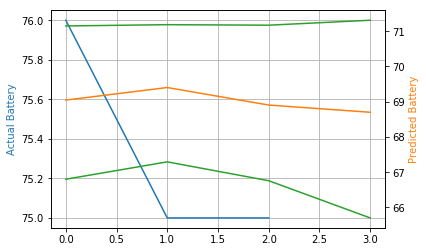

In [54]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Actual Battery', color='C0')
ax2.set_ylabel('Predicted Battery', color='C1')


ax1.plot(actual, color='C0')
ax2.plot(mean, color='C1')
ax2.plot(q01, color='C2')
ax2.plot(q90, color='C2')


## DeepAR Optimization

In [56]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.2",
          "MinValue": "0.0",
          "Name": "dropout_rate"
        },
        {
          "MaxValue": "0.00001",
          "MinValue": "0.1",
          "Name": "learning_rate"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "1028",
          "MinValue": "32",
          "Name": "mini_batch_size"
        },
        {
          "MaxValue": "1000",
          "MinValue": "1",
          "Name": "epochs"
        },
        {
          "MaxValue": "200",
          "MinValue": "1",
          "Name": "context_length"
        },
        {
          "MaxValue": "200",
          "MinValue": "30",
          "Name": "num_cells"
        }, 
        {
          "MaxValue": "8",
          "MinValue": "1",
          "Name": "num_layers"
        }, 
        {
          "MaxValue": "50",
          "MinValue": "1",
          "Name": "embedding_dimension"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 50,
      "MaxParallelTrainingJobs": 5
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "test:RMSE",
      "Type": "Minimize"
    }
  }